# Klasyfikacja rodzajów szkła

Import bibliotek i definicja funkcji pomocniczych

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV


Bad key "text.kerning_factor" on line 4 in
E:\Program Files\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def verify(model, dataset, atr, method):
    model.fit(dataset["trainX"].loc[:,atr], dataset["trainY"])
    trainPredict = model.predict(dataset["trainX"].loc[:,atr])
    testPredict = model.predict(dataset["testX"].loc[:,atr])
    crosstab = pd.crosstab(dataset["trainY"], trainPredict)
    plt.figure(figsize=(10,3.5))
    plt.subplot(1,2,1)
    sns.heatmap(crosstab, annot=crosstab)
    plt.title('Macierz pomyłek dla zbioru uczącego,\n' + method)
    crosstab = pd.crosstab(dataset["testY"], testPredict) 
    plt.subplot(1,2,2)
    sns.heatmap(crosstab, annot=crosstab)
    plt.title('Macierz pomyłek dla zbioru testowego,\n' + method)
    trainScore = model.score(dataset['trainX'].loc[:,atr],dataset['trainY'])
    testScore = model.score(dataset['testX'].loc[:,atr],dataset['testY'])
    print('trainScore: ', trainScore)
    print('testScore: ', testScore)

In [3]:
def get_parametrized_knn(k):
    return KNeighborsClassifier(n_neighbors=k)

In [4]:
def scores(params, dataset, model_type):
    scores = np.zeros(len(params))
    
    if model_type == 'knn':
        fun = get_parametrized_knn
        
    for i, param in enumerate(params):
        model = fun(param)
        model.fit(dataset['trainX'],dataset['trainY'])
        testPredict = model.predict(dataset['testX'])
        testScore = accuracy_score(dataset['testY'], testPredict)
        scores[i] = testScore
        
    return scores

In [5]:
def create_dataset(df, percent):
    dataset = split(df, percent)
    scaler = StandardScaler()
    trainX = scaler.fit_transform(dataset['trainX'])
    testX = scaler.transform(dataset['testX'])
    features = list(df.columns[:-1])
    dataset['trainX'] = pd.DataFrame(data=trainX, columns=features)
    dataset['testX'] = pd.DataFrame(data=testX, columns=features)
    return dataset

In [6]:
def split(df, percent, random_state=True):
    trainX, testX, trainY, testY = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1].astype('category').cat.codes, test_size=percent)#, random_state=random_state)
    return {"trainX":trainX, "testX":testX, "trainY":trainY, "testY":testY}

In [7]:
# Detect observations with more than one outlier

def find_outliers(df):

    outlier_indices = []
    for col in df.columns.tolist():
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers    

In [8]:
# Filtr IQR
def iqr_filter(df):
    new_df = df.copy()
    n_rows = len(new_df)
    n_cols = len(new_df.columns)

    for col in range(n_cols):
        q1 = df.quantile(0.25)[col]
        q3 = df.quantile(0.75)[col]
        iqr = q3 - q1

        mean = np.mean(new_df.iloc[:, col])

        for i in range(n_rows):
            if (new_df.iloc[i, col] < q1 - 1.5 * iqr) | (new_df.iloc[i, col] > q3 + 1.5 * iqr):
                new_df.iloc[i, col] = mean

    return new_df

### Analiza zbioru danych

In [9]:
df = pd.read_csv('glass_dataset.csv')
df

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1
...,...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7


In [10]:
print("Obiektów =", df.shape[0])
print('Atrybutów =', df.shape[1])
classes = df.iloc[:,-1]
print('Klas =',classes.unique().shape[0])
for i in list(classes.unique()):
    print('Obiektów w klasie ', i, ' = ', len(df[df['Type'] == i]))
print("Braków =",df.isnull().sum().sum())
features = df.columns[0:-1].tolist()
classes = classes.unique().tolist()

Obiektów = 214
Atrybutów = 10
Klas = 6
Obiektów w klasie  1  =  70
Obiektów w klasie  2  =  76
Obiektów w klasie  3  =  17
Obiektów w klasie  5  =  13
Obiektów w klasie  6  =  9
Obiektów w klasie  7  =  29
Braków = 0


### Macierz wykresów punktowych

E:\Program Files\Anaconda\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
E:\Program Files\Anaconda\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
E:\Program Files\Anaconda\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.02, 'Macierz wykresów punktowych (wszystkie atrybuty)')

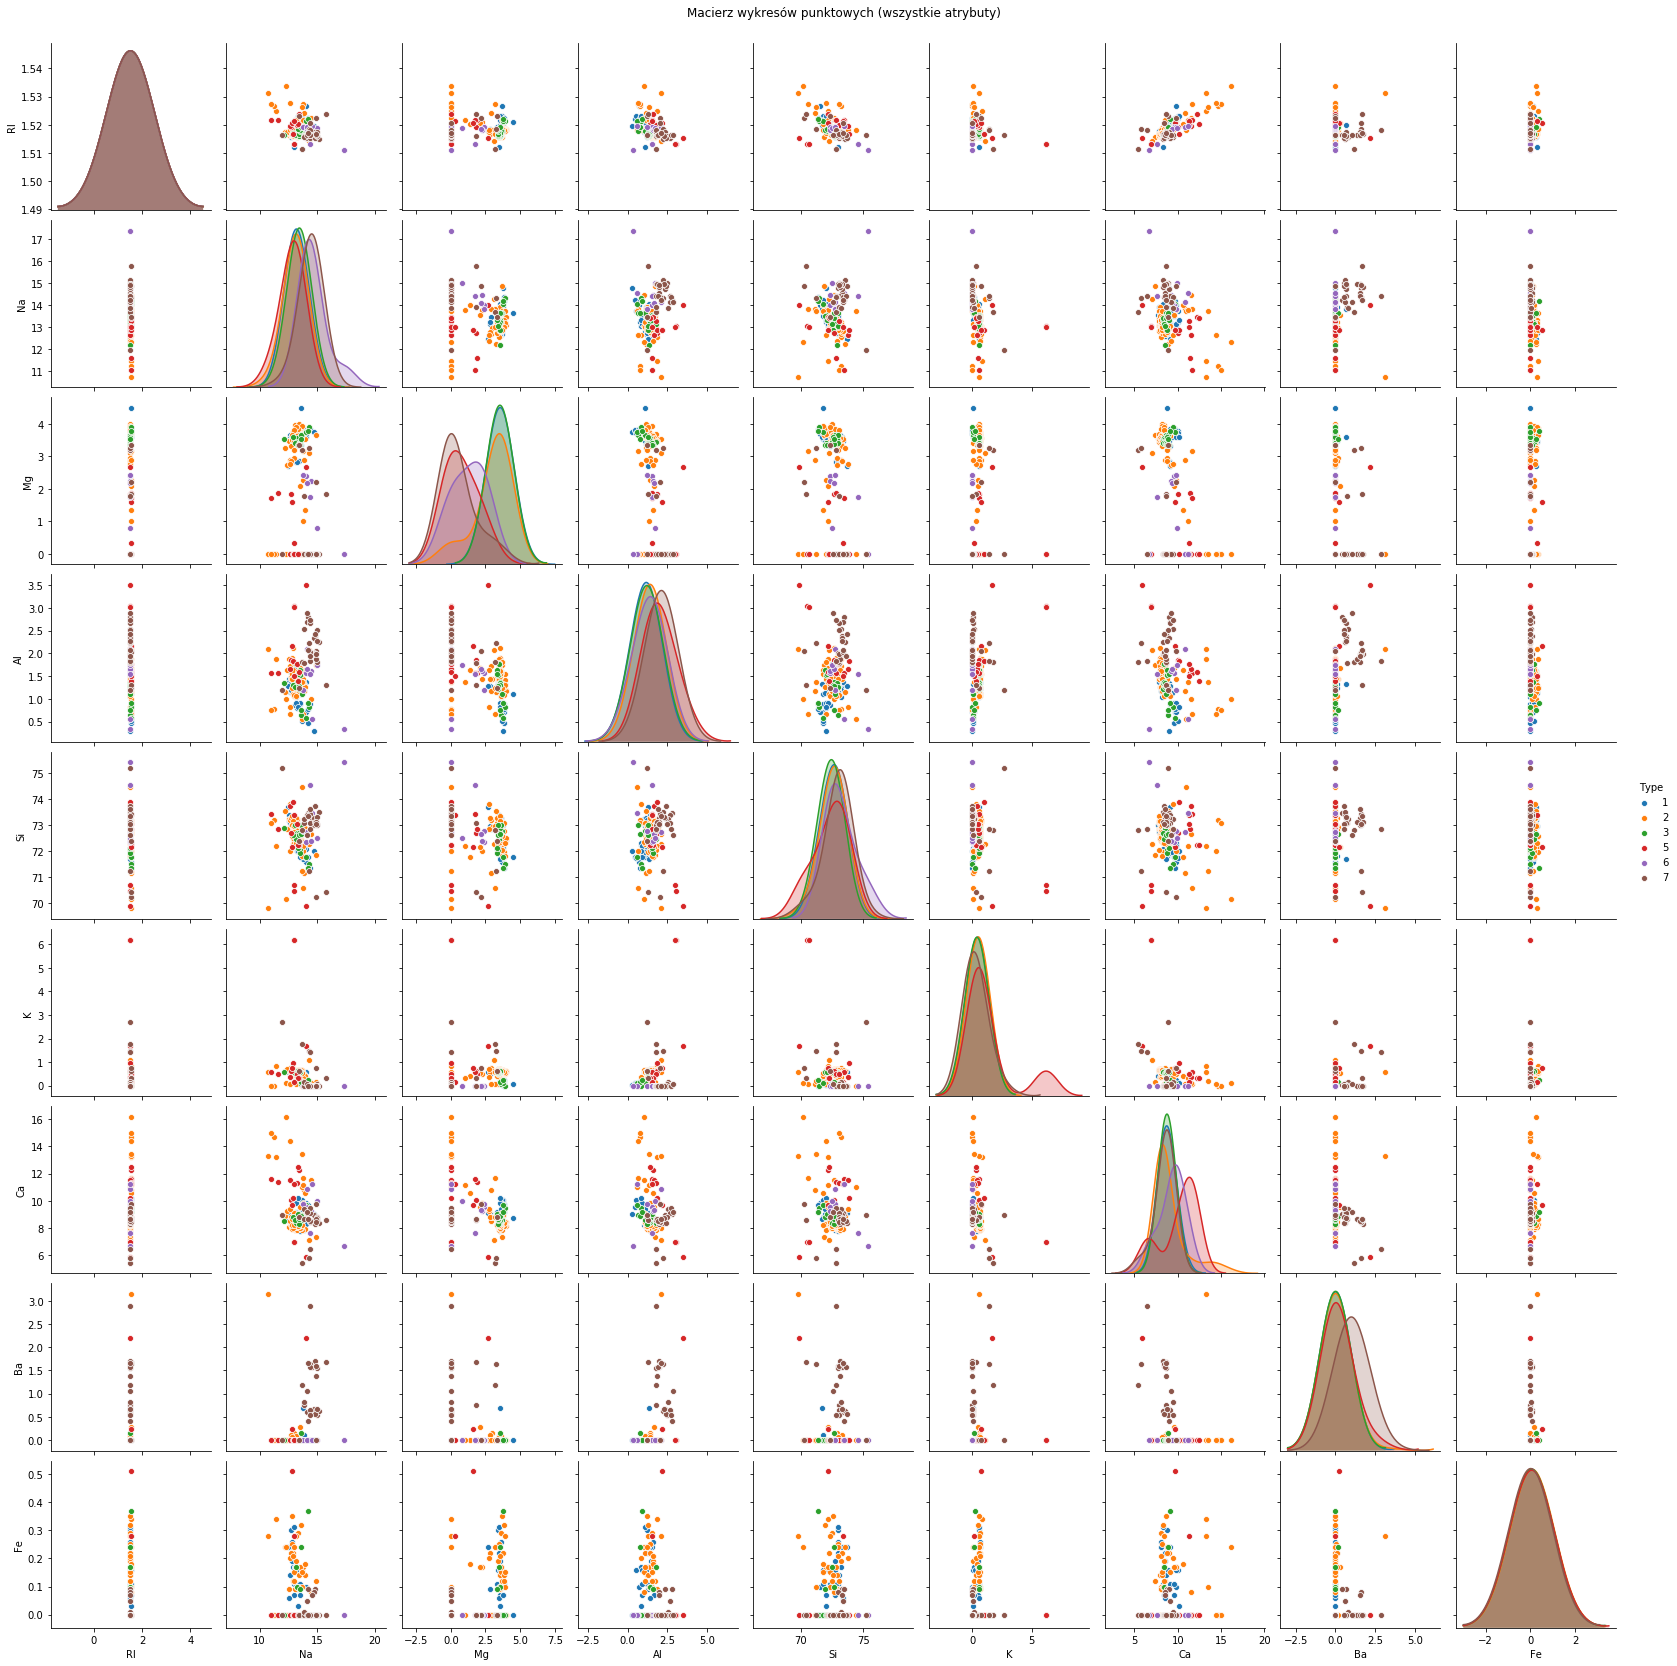

In [11]:
sns.pairplot(df, kind='scatter',
             hue='Type', diag_kws={'bw':1.0}) \
            .fig.suptitle('Macierz wykresów punktowych (wszystkie atrybuty)',
                         y=1.02)

### Korelacja atrybutów

Text(0.5, 1, 'Mapa ciepła')

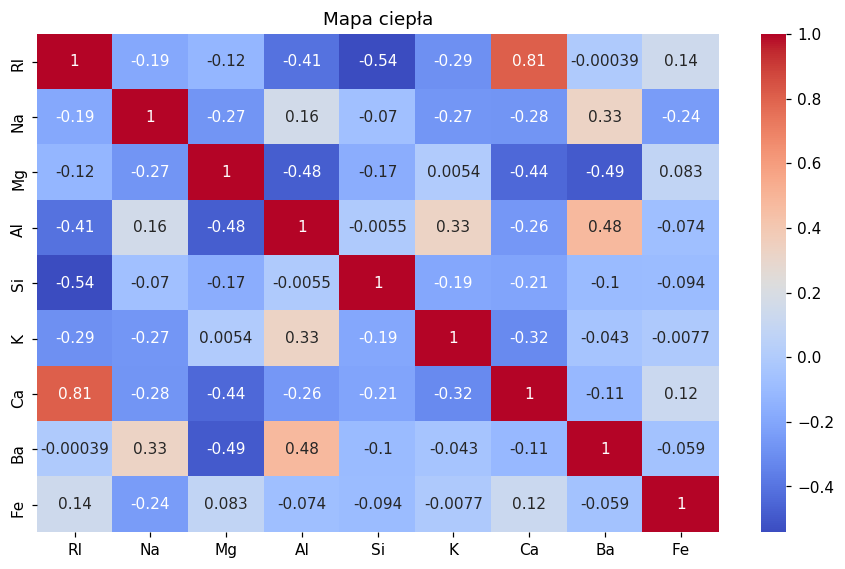

In [12]:
corr = df.drop(columns=['Type']).corr()
plt.figure(figsize=(10,6), dpi=110)
sns.heatmap(corr, annot=corr, cmap= 'coolwarm')
plt.title('Mapa ciepła')

### Szukanie wartości odstających

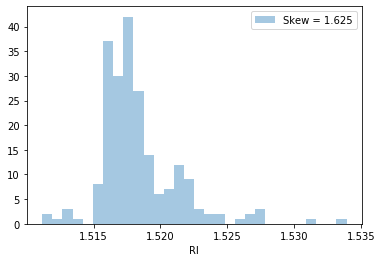

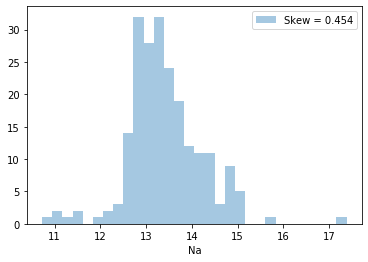

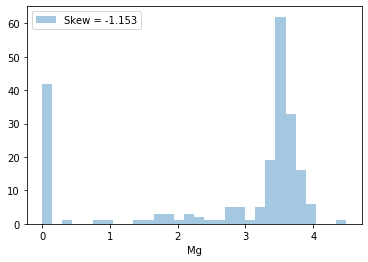

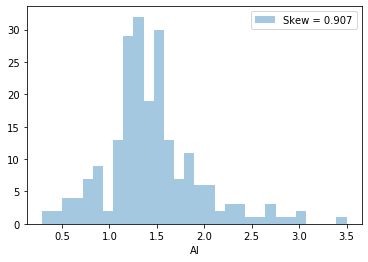

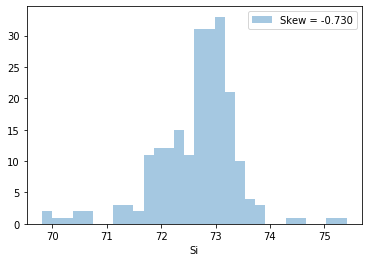

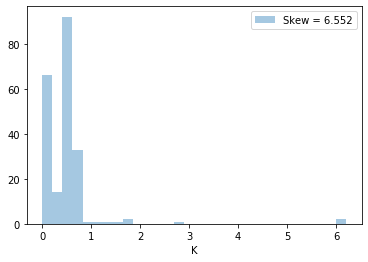

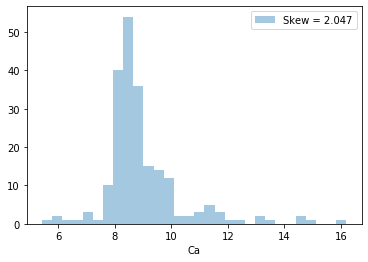

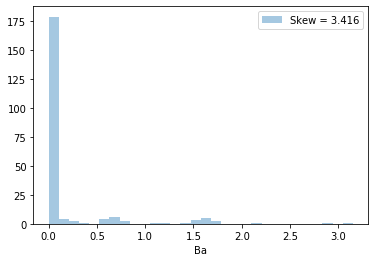

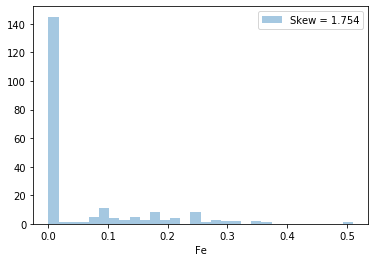

In [13]:
for feature in features:
    skew = df[feature].skew()
    sns.distplot(df[feature], kde=False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [14]:
outliers = find_outliers(df[features])
print('Zbiór danych zawiera %d obserwacji z więcej niż dwoma wartościami odstającymi' %(len(outliers)))  

Zbiór danych zawiera 14 obserwacji z więcej niż dwoma wartościami odstającymi


In [15]:
#Usuwanie obserwacji z więcej niż dwoma wartościami odstającymi
df_outliers = df.drop(outliers).reset_index(drop=True)

#filtr IQR
classes = df.iloc[:,-1]
df_out = iqr_filter(df[features])
df_out = pd.DataFrame(columns=features, data=df_out)
df_out['Type'] = classes
print(df_out)
print(df_outliers)

#wybór usuwania wartości odstających
df_before_rem_outl = df
df = df_outliers
#df = df_out

          RI     Na    Mg        Al     Si     K    Ca        Ba   Fe  Type
0    1.52101  13.64  4.49  1.100000  71.78  0.06  8.75  0.000000  0.0     1
1    1.51761  13.89  3.60  1.360000  72.73  0.48  7.83  0.000000  0.0     1
2    1.51618  13.53  3.55  1.540000  72.99  0.39  7.78  0.000000  0.0     1
3    1.51766  13.21  3.69  1.290000  72.61  0.57  8.22  0.000000  0.0     1
4    1.51742  13.27  3.62  1.240000  73.08  0.55  8.07  0.000000  0.0     1
..       ...    ...   ...       ...    ...   ...   ...       ...  ...   ...
209  1.51623  14.14  0.00  1.444907  72.61  0.08  9.18  0.175047  0.0     7
210  1.51685  14.92  0.00  1.990000  73.06  0.00  8.40  0.175047  0.0     7
211  1.52065  14.36  0.00  2.020000  73.42  0.00  8.44  0.175047  0.0     7
212  1.51651  14.38  0.00  1.940000  73.61  0.00  8.48  0.175047  0.0     7
213  1.51711  14.23  0.00  2.080000  73.36  0.00  8.62  0.175047  0.0     7

[214 rows x 10 columns]
          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  

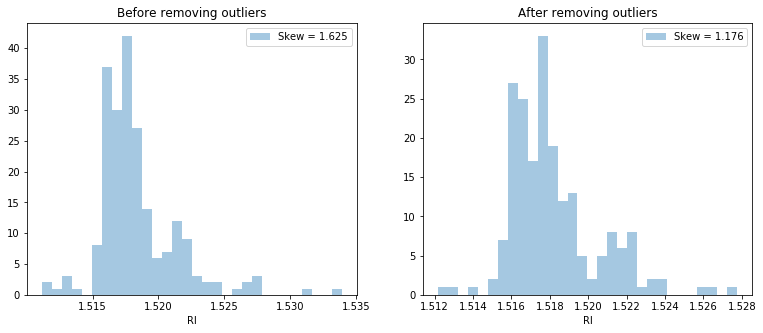

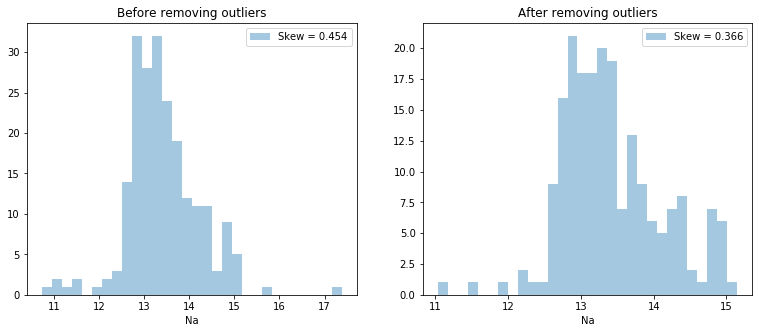

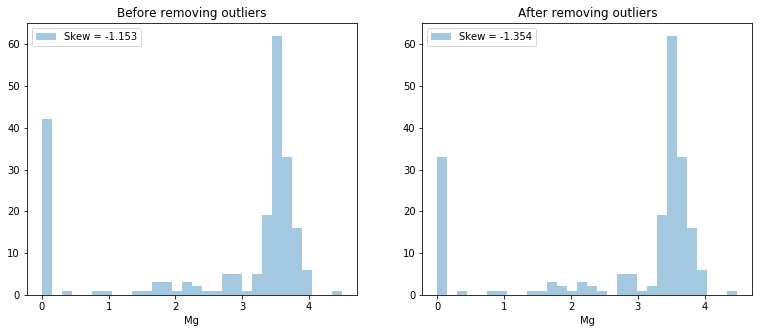

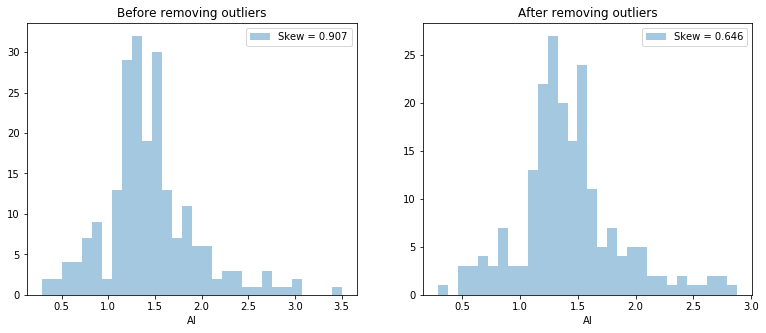

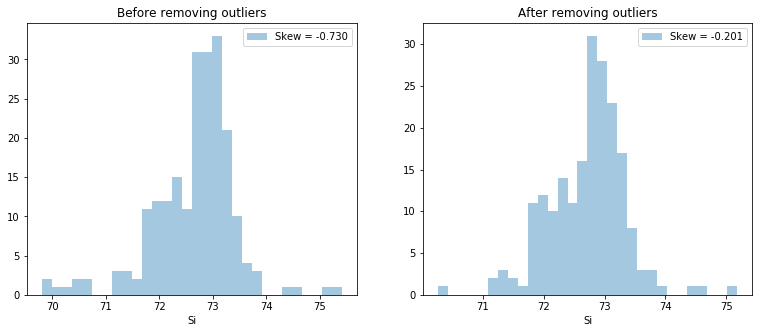

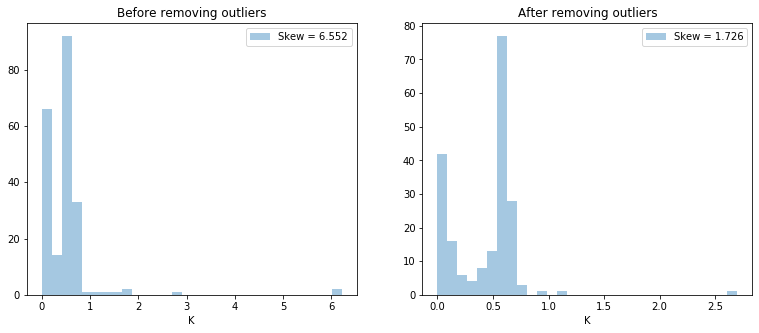

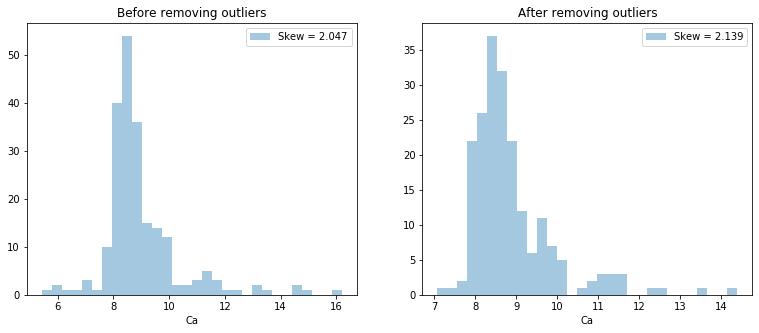

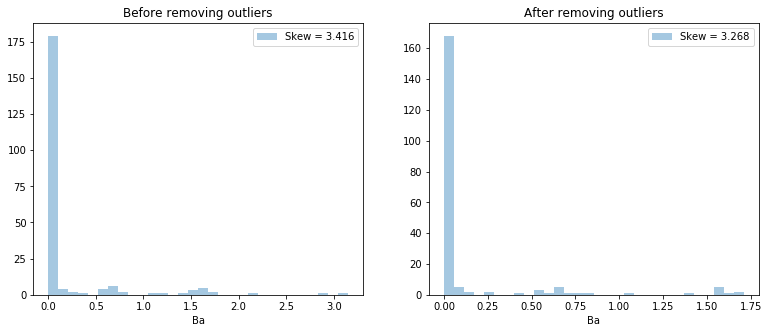

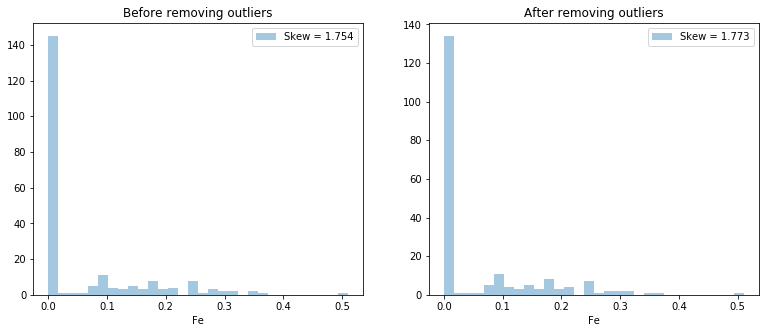

In [16]:
for feature in features:
    skew_before = df_before_rem_outl[feature].skew()
    skew = df[feature].skew()
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(13, 5)
    
    sns.distplot(df_before_rem_outl[feature], 
                 kde=False, label='Skew = %.3f' %(skew_before), bins=30, ax=ax1)
    
    ax1.set_title('Before removing outliers')
    ax1.legend(loc='best')
    
    sns.distplot(df[feature],
                 kde=False, label='Skew = %.3f' %(skew), bins=30, ax=ax2)
    ax2.set_title('After removing outliers')
    ax2.legend(loc='best')
    
    plt.show()

### Statystyki

In [17]:
df.drop(columns='Type').describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000
mean,1.518173,13.41575,2.801850,1.424950,72.722250,0.428700,8.90035,0.123650,0.056700
std,0.002335,0.69161,1.370908,0.444292,0.620959,0.304392,1.03586,0.362892,0.095718
min,1.512150,11.03000,0.000000,0.290000,70.260000,0.000000,7.08000,0.000000,0.000000
25%,1.516545,12.93000,2.635000,1.190000,72.355000,0.130000,8.27750,0.000000,0.000000
50%,1.517650,13.30000,3.495000,1.360000,72.820000,0.550000,8.60000,0.000000,0.000000
75%,1.519060,13.79500,3.610000,1.612500,73.100000,0.600000,9.14000,0.000000,0.100000
max,1.527770,15.15000,4.490000,2.880000,75.180000,2.700000,14.40000,1.710000,0.510000


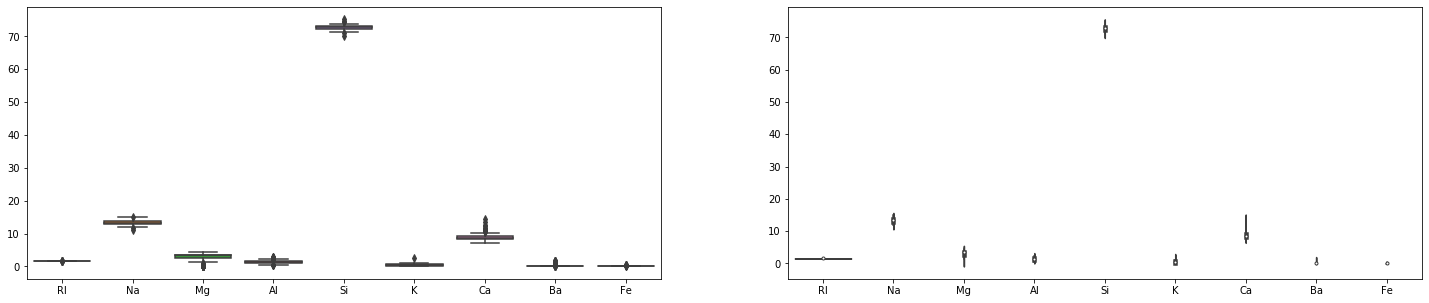

In [18]:
plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
sns.boxplot(data=df.drop(columns=['Type']))
plt.subplot(1,2,2)
sns.violinplot(data=df.drop(columns=['Type']))

#### Widać dużą różnicę w zakresach atrybutów. Oznacza to, że standaryzacja jest potrzebna.

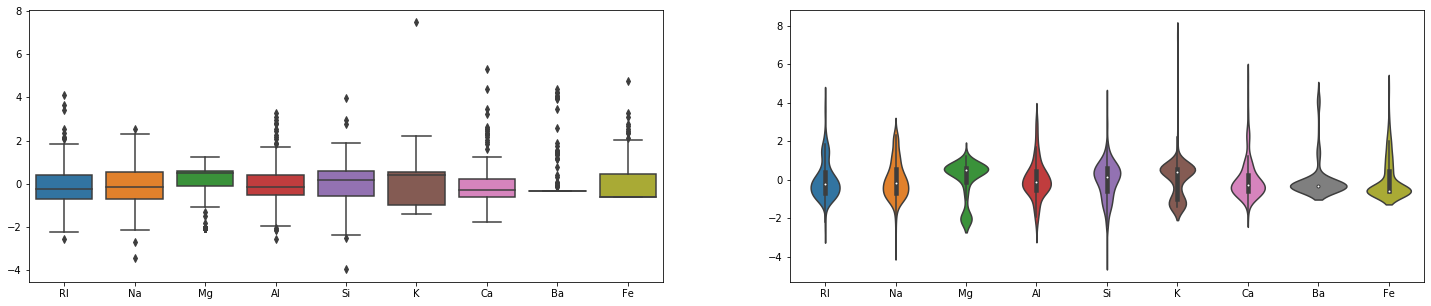

In [19]:
df_scaled = StandardScaler().fit_transform(df.iloc[:,:-1])
df_scaled = pd.DataFrame(columns=features, data=df_scaled)
df_scaled['Type'] = df['Type']

fig = plt.figure(figsize=(25,5))
plt.subplot(1,2,1)
sns.boxplot(data=df_scaled.drop(columns=['Type']))
plt.subplot(1,2,2)
sns.violinplot(data=df_scaled.drop(columns=['Type']))
fig.title = 'Po standaryzacji atrybutów'

In [20]:
df_scaled.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,2.000000e+02,200.000000
mean,-9.534040e-16,3.906875e-15,-3.996803e-17,1.609823e-16,-4.025669e-15,5.107026e-17,-1.317280e-15,-5.950795e-16,6.328271e-17,2.670000
std,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,1.002509e+00,2.054802
min,-2.585723e+00,-3.458217e+00,-2.048921e+00,-2.560927e+00,-3.975186e+00,-1.411915e+00,-1.761742e+00,-3.415900e-01,-5.938521e-01,1.000000
25%,-6.990391e-01,-7.041094e-01,-1.220131e-01,-5.301465e-01,-5.929078e-01,-9.837624e-01,-6.027968e-01,-3.415900e-01,-5.938521e-01,1.000000
50%,-2.246850e-01,-1.677832e-01,5.068827e-01,-1.465546e-01,1.578128e-01,3.994991e-01,-2.906800e-01,-3.415900e-01,-5.938521e-01,2.000000
75%,3.805994e-01,5.497344e-01,5.909792e-01,4.231920e-01,6.098596e-01,5.641731e-01,2.319343e-01,-3.415900e-01,4.535061e-01,3.000000
max,4.119626e+00,2.513848e+00,1.234500e+00,3.283208e+00,3.967921e+00,7.480481e+00,5.322584e+00,4.382380e+00,4.747675e+00,7.000000


### Sprawdzanie użyteczności atrybutów do klasyfikacji za pomocą grupowania 

In [21]:
groups = df_scaled.iloc[:,-1]
df_g = df_scaled.drop('Type', axis=1)
df_g

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.217695,0.325057,1.234500,-0.733224,-1.521218,-1.214306,-0.145509,-0.341590,-0.593852
1,-0.241856,0.687440,0.583666,-0.146555,0.012512,0.168956,-1.035889,-0.341590,-0.593852
2,-0.855726,0.165609,0.547103,0.259601,0.432270,-0.127458,-1.084279,-0.341590,-0.593852
3,-0.220392,-0.298241,0.649481,-0.304504,-0.181222,0.465369,-0.658446,-0.341590,-0.593852
4,-0.323419,-0.211269,0.598292,-0.417325,0.577570,0.399499,-0.803616,-0.341590,-0.593852
...,...,...,...,...,...,...,...,...,...
195,-0.834262,1.049822,-2.048921,3.283208,-0.181222,-1.148436,0.270646,2.586719,-0.593852
196,-0.568109,2.180456,-2.048921,1.274992,0.545281,-1.411915,-0.484241,4.050873,-0.593852
197,1.063154,1.368719,-2.048921,1.342684,1.126484,-1.411915,-0.445529,4.189001,-0.593852
198,-0.714064,1.397710,-2.048921,1.162170,1.433230,-1.411915,-0.406816,3.995622,-0.593852


### Grupowanie z uwzględnieniem wszystkich atrybutów

Text(0.5, 1, 'macierz pomyłek')

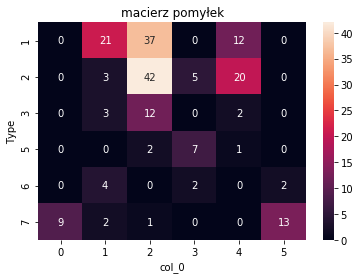

In [22]:
classes = classes.unique()
kmeans = KMeans(n_clusters = len(classes), random_state=100)
groupsPredicted = kmeans.fit_predict(df_g)
mistakes = pd.crosstab(groups,groupsPredicted)
sns.heatmap(mistakes,annot = mistakes)
plt.title('macierz pomyłek')

### Grupowanie po odrzuceniu Fe 

In [23]:
df_g = df_g.drop('Fe', axis=1)

Text(0.5, 1, 'macierz pomyłek')

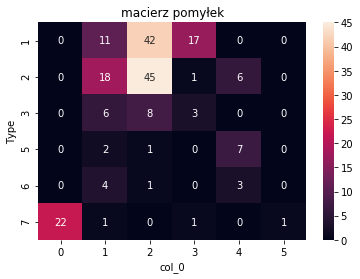

In [24]:
kmeans = KMeans(n_clusters = len(classes), random_state=100)
groupsPredicted = kmeans.fit_predict(df_g)
pomylki = pd.crosstab(groups,groupsPredicted)
sns.heatmap(pomylki,annot = pomylki)
plt.title('macierz pomyłek')

### Grupowanie po odrzuceniu Fe i RI

In [25]:
df_g = df_g.drop('RI', axis=1)

Text(0.5, 1, 'macierz pomyłek')

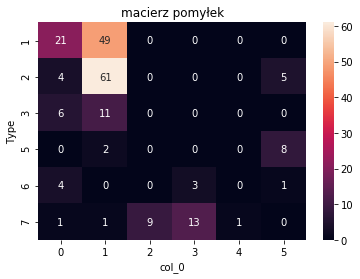

In [26]:
kmeans = KMeans(n_clusters = len(classes), random_state=100)
groupsPredicted = kmeans.fit_predict(df_g)
pomylki = pd.crosstab(groups,groupsPredicted)
sns.heatmap(pomylki,annot = pomylki)
plt.title('macierz pomyłek')

# KNN - szukanie najlepszej liczby sąsiadów

In [27]:
kvals = range(1,16)
knn_scores = pd.DataFrame(columns=kvals)
n = 1000
percent = 0.25

for i in range(n):
    dataset = create_dataset(df, percent)
    score = scores(kvals, dataset, model_type='knn')
    knn_scores.loc[len(knn_scores)] = score

In [28]:
knn_scores

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.66,0.68,0.68,0.66,0.64,0.68,0.64,0.68,0.68,0.70,0.66,0.68,0.68,0.68,0.68
1,0.80,0.76,0.72,0.72,0.74,0.70,0.70,0.70,0.72,0.68,0.66,0.70,0.70,0.70,0.68
2,0.66,0.72,0.68,0.72,0.70,0.72,0.64,0.70,0.66,0.68,0.66,0.68,0.64,0.64,0.64
3,0.72,0.74,0.66,0.74,0.72,0.70,0.70,0.68,0.68,0.70,0.72,0.68,0.68,0.68,0.68
4,0.72,0.70,0.76,0.62,0.64,0.66,0.62,0.64,0.62,0.66,0.66,0.70,0.68,0.68,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.70,0.66,0.64,0.62,0.54,0.58,0.54,0.60,0.58,0.58,0.54,0.54,0.56,0.56,0.54
996,0.82,0.78,0.84,0.80,0.80,0.76,0.76,0.74,0.78,0.78,0.74,0.74,0.74,0.72,0.70
997,0.58,0.72,0.74,0.70,0.70,0.72,0.70,0.68,0.62,0.64,0.62,0.64,0.60,0.58,0.62
998,0.72,0.70,0.70,0.68,0.66,0.64,0.72,0.70,0.66,0.66,0.66,0.64,0.66,0.66,0.64


In [29]:
knn_scores.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.72158,0.702420,0.701120,0.683800,0.669400,0.669360,0.657400,0.65834,0.648900,0.650520,0.643140,0.641280,0.635720,0.632600,0.631660
std,0.05555,0.058988,0.057714,0.059298,0.059268,0.059773,0.060558,0.05993,0.062753,0.062505,0.060807,0.062794,0.063272,0.063753,0.062741
min,0.52000,0.480000,0.520000,0.480000,0.480000,0.500000,0.460000,0.50000,0.460000,0.480000,0.440000,0.440000,0.420000,0.400000,0.400000
25%,0.68000,0.660000,0.660000,0.640000,0.640000,0.640000,0.620000,0.62000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000
50%,0.72000,0.700000,0.700000,0.680000,0.680000,0.680000,0.660000,0.66000,0.660000,0.660000,0.640000,0.640000,0.640000,0.640000,0.640000
75%,0.76000,0.740000,0.740000,0.720000,0.720000,0.720000,0.700000,0.70000,0.700000,0.700000,0.680000,0.680000,0.680000,0.680000,0.680000
max,0.90000,0.900000,0.860000,0.860000,0.840000,0.840000,0.820000,0.82000,0.840000,0.820000,0.820000,0.840000,0.820000,0.840000,0.820000


In [30]:
print('Liczba sąsiadów, dla której średni wynik przy %d uruchomieniach jest najlepszy: %d' % (n, knn_scores.mean().idxmax()))
print('Średni wynik dla najlepszej liczby sąsiadów: %.4f' % (knn_scores.mean().max()))
print('Najlepszy wynik: %.4f, liczba sąsiadów: %d' % ((knn_scores.max().max()), knn_scores.max().idxmax()))
print('Najgorszy wynik: %.4f, liczba sąsiadów: %d' % ((knn_scores.min().min()), knn_scores.min().idxmin()))

Liczba sąsiadów, dla której średni wynik przy 1000 uruchomieniach jest najlepszy: 1
Średni wynik dla najlepszej liczby sąsiadów: 0.7216
Najlepszy wynik: 0.9000, liczba sąsiadów: 1
Najgorszy wynik: 0.4000, liczba sąsiadów: 14


### Przykładowy wynik

trainScore:  1.0
testScore:  0.6


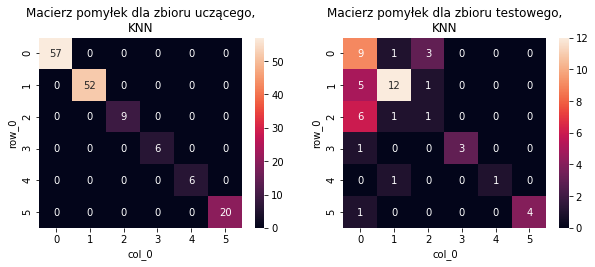

In [31]:
percent = 0.25
dataset = create_dataset(df, percent)
model = KNeighborsClassifier(n_neighbors=1)
verify(model, dataset, features, 'KNN')

# Nearest Centroid

In [32]:
nc_scores = []
n = 1000
percent = 0.25

for i in range(n):
    dataset = create_dataset(df, percent)
    model = NearestCentroid()
    model.fit(dataset['trainX'],dataset['trainY'])
    testPredict = model.predict(dataset['testX'])
    testScore = accuracy_score(dataset['testY'], testPredict)
    nc_scores.append(testScore)
    
nc_scores = np.array(nc_scores)

In [33]:
print('Średni wynik: %.4f przy %d uruchomieniach' % (np.mean(nc_scores), n))
print('Najlepszy wynik: %.4f' % (np.max(nc_scores)))
print('Najgorszy wynik: %.4f' % (np.min(nc_scores)))

Średni wynik: 0.5174 przy 1000 uruchomieniach
Najlepszy wynik: 0.7400
Najgorszy wynik: 0.3000


# GaussianNB

In [34]:
nb_scores = []
n = 1000
percent = 0.25

for i in range(n):
    dataset = create_dataset(df, percent)
    model = GaussianNB()
    model.fit(dataset['trainX'],dataset['trainY'])
    testPredict = model.predict(dataset['testX'])
    testScore = accuracy_score(dataset['testY'], testPredict)
    nb_scores.append(testScore)
    
nb_scores = np.array(nb_scores)

In [35]:
print('Średni wynik: %.4f przy %d uruchomieniach' % (np.mean(nb_scores), n))
print('Najlepszy wynik: %.4f' % (np.max(nb_scores)))
print('Najgorszy wynik: %.4f' % (np.min(nb_scores)))

Średni wynik: 0.4981 przy 1000 uruchomieniach
Najlepszy wynik: 0.7800
Najgorszy wynik: 0.1400


# Decision Tree

In [36]:
percent = 0.25
grid_dataset = create_dataset(df, percent)

In [37]:
parameters =  { "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
                "min_samples_split": [2, 5, 10, 15, 20],
                "min_samples_leaf": [1, 2, 4, 6, 8, 10],
                "criterion": ["gini", "entropy"]
              }
model = tree.DecisionTreeClassifier()
percent = 0.25
classifier_dt = GridSearchCV(estimator = model,
                                  param_grid = parameters,
                                  verbose = 4,
                                  n_jobs = -1)
classifier_dt = classifier_dt.fit(grid_dataset['trainX'], grid_dataset['trainY'])

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


E:\Program Files\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 2016 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:    7.2s finished


In [38]:
classifier_dt.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [39]:
dt_scores = []
n = 1000
percent = 0.25

for i in range(n):
    dataset = create_dataset(df, percent)
    model = tree.DecisionTreeClassifier(**classifier_dt.best_params_)
    model.fit(dataset['trainX'],dataset['trainY'])
    testPredict = model.predict(dataset['testX'])
    testScore = accuracy_score(dataset['testY'], testPredict)
    dt_scores.append(testScore)
    
dt_scores = np.array(dt_scores)

In [40]:
print('Średni wynik dla najlepszych parametrów: %.4f' % (dt_scores.mean().max()))
print('Najlepszy wynik: %.4f' % ((dt_scores.max().max())))
print('Najgorszy wynik: %.4f' % ((dt_scores.min().min())))

Średni wynik dla najlepszych parametrów: 0.6754
Najlepszy wynik: 0.9000
Najgorszy wynik: 0.4400


### Przykładowy wynik

trainScore:  1.0
testScore:  0.62


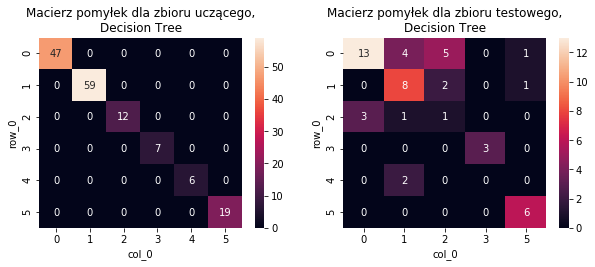

In [41]:
percent = 0.25
dataset = create_dataset(df, percent)
model = tree.DecisionTreeClassifier(**classifier_dt.best_params_)
verify(model, dataset, features, 'Decision Tree')

# Random Forest

In [42]:
parameters =  { "n_estimators": [300],
                "max_features": [2, 3, 4, 5, 6],
                "max_depth": [2, 3, 4, 5, 6],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"]
              }
model = RandomForestClassifier()
percent = 0.25
classifier_rf = GridSearchCV(estimator = model,
                                  param_grid = parameters,
                                  verbose = 4,
                                  n_jobs = -1)
classifier_rf = classifier_rf.fit(grid_dataset['trainX'], grid_dataset['trainY'])


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


E:\Program Files\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed:   59.8s
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2949 tasks      | elapsed:  5.2min
[Parallel(n_

In [43]:
classifier_rf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

In [44]:
rf_scores = []
n = 100
percent = 0.25

for i in range(n):
    dataset = create_dataset(df, percent)
    model = RandomForestClassifier(**classifier_rf.best_params_)
    model.fit(dataset['trainX'],dataset['trainY'])
    testPredict = model.predict(dataset['testX'])
    testScore = accuracy_score(dataset['testY'], testPredict)
    rf_scores.append(testScore)
    
rf_scores = np.array(rf_scores)

In [45]:
rf_scores

array([0.7 , 0.78, 0.84, 0.7 , 0.76, 0.78, 0.72, 0.76, 0.78, 0.84, 0.78,
       0.66, 0.7 , 0.74, 0.72, 0.8 , 0.8 , 0.8 , 0.68, 0.84, 0.78, 0.7 ,
       0.86, 0.72, 0.8 , 0.86, 0.78, 0.78, 0.76, 0.9 , 0.8 , 0.64, 0.74,
       0.74, 0.76, 0.7 , 0.86, 0.6 , 0.82, 0.74, 0.6 , 0.8 , 0.82, 0.72,
       0.84, 0.72, 0.84, 0.74, 0.78, 0.72, 0.74, 0.82, 0.82, 0.86, 0.74,
       0.78, 0.78, 0.78, 0.78, 0.66, 0.72, 0.68, 0.72, 0.8 , 0.84, 0.68,
       0.72, 0.7 , 0.74, 0.8 , 0.82, 0.68, 0.7 , 0.8 , 0.82, 0.76, 0.82,
       0.74, 0.8 , 0.78, 0.82, 0.84, 0.72, 0.82, 0.8 , 0.76, 0.76, 0.78,
       0.76, 0.76, 0.74, 0.82, 0.72, 0.74, 0.72, 0.76, 0.8 , 0.76, 0.82,
       0.8 ])

In [46]:
print('Średni wynik dla najlepszych parametrów: %.4f' % (rf_scores.mean().max()))
print('Najlepszy wynik: %.4f' % ((rf_scores.max().max())))
print('Najgorszy wynik: %.4f' % ((rf_scores.min().min())))

Średni wynik dla najlepszych parametrów: 0.7648
Najlepszy wynik: 0.9000
Najgorszy wynik: 0.6000


### Przykładowy wynik

trainScore:  1.0
testScore:  0.7


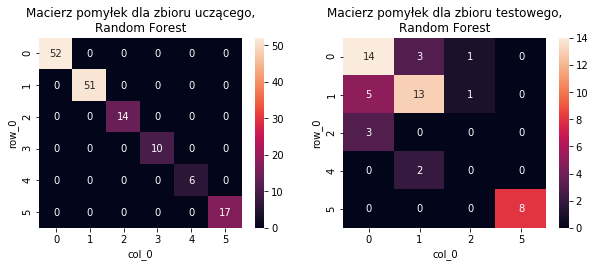

In [47]:
percent = 0.25
dataset = create_dataset(df, percent)
model = RandomForestClassifier(n_estimators=1000)
verify(model, dataset, features, 'Random Forest')

# SVM

In [48]:
parameters =  { "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
                "degree": [1, 2, 3, 4, 5],
                "gamma": ["scale", "auto"]
              }
model = svm.SVC()
percent = 0.25
classifier_svm = GridSearchCV(estimator = model,
                                  param_grid = parameters,
                                  verbose = 4,
                                  n_jobs = -1)
classifier_svm = classifier_svm.fit(grid_dataset['trainX'], grid_dataset['trainY'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


E:\Program Files\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished


In [49]:
classifier_svm.best_params_

{'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [50]:
svm_scores = []
n = 100
percent = 0.25

for i in range(n):
    dataset = create_dataset(df, percent)
    model = svm.SVC(**classifier_svm.best_params_)
    model.fit(dataset['trainX'],dataset['trainY'])
    testPredict = model.predict(dataset['testX'])
    testScore = accuracy_score(dataset['testY'], testPredict)
    svm_scores.append(testScore)
    
svm_scores = np.array(svm_scores)

In [51]:
print('Średni wynik: %.4f przy %d uruchomieniach' % (np.mean(svm_scores), n))
print('Najlepszy wynik: %.4f' % (np.max(svm_scores)))
print('Najgorszy wynik: %.4f' % (np.min(svm_scores)))

Średni wynik: 0.6918 przy 100 uruchomieniach
Najlepszy wynik: 0.8200
Najgorszy wynik: 0.5200


### Przykładowy wynik

trainScore:  0.7666666666666667
testScore:  0.74


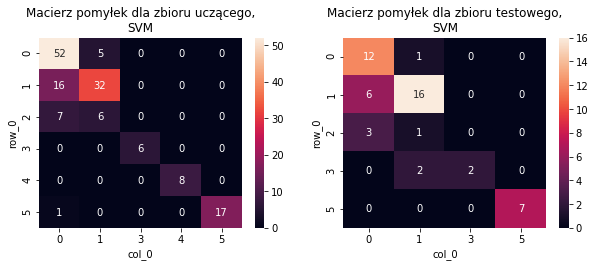

In [52]:
percent = 0.25
dataset = create_dataset(df, percent)
model = svm.SVC(**classifier_svm.best_params_)
verify(model, dataset, features, 'SVM')

# Porównanie klasyfikatorów

In [53]:
def compareClassifiers(df):
    knn_scores = []
    nc_scores = []
    nb_scores = []
    dt_scores = []
    rf_scores = []
    svm_scores = []
    n = 100
    percent = 0.25
    n_neighbors = 1

    for i in range(n):
        dataset = create_dataset(df, percent)
        #KNN
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(dataset['trainX'],dataset['trainY'])
        testPredict = model.predict(dataset['testX'])
        testScore = accuracy_score(dataset['testY'], testPredict)
        knn_scores.append(testScore)
    
        #NearestCentroid
        model = NearestCentroid()
        model.fit(dataset['trainX'],dataset['trainY'])
        testPredict = model.predict(dataset['testX'])
        testScore = accuracy_score(dataset['testY'], testPredict)
        nc_scores.append(testScore)
    
        #GaussianNB
        model = GaussianNB()
        model.fit(dataset['trainX'],dataset['trainY'])
        testPredict = model.predict(dataset['testX'])
        testScore = accuracy_score(dataset['testY'], testPredict)
        nb_scores.append(testScore)
    
        #DecisionTree
        model = tree.DecisionTreeClassifier(**classifier_dt.best_params_)
        model.fit(dataset['trainX'],dataset['trainY'])
        testPredict = model.predict(dataset['testX'])
        testScore = accuracy_score(dataset['testY'], testPredict)
        dt_scores.append(testScore)
    
        #RandomForest
        model = RandomForestClassifier(**classifier_rf.best_params_)
        model.fit(dataset['trainX'],dataset['trainY'])
        testPredict = model.predict(dataset['testX'])
        testScore = accuracy_score(dataset['testY'], testPredict)
        rf_scores.append(testScore)
    
        #SVM
        model = svm.SVC(**classifier_svm.best_params_)
        model.fit(dataset['trainX'],dataset['trainY'])
        testPredict = model.predict(dataset['testX'])
        testScore = accuracy_score(dataset['testY'], testPredict)
        svm_scores.append(testScore)
        
    return  knn_scores, nc_scores, nb_scores, dt_scores, rf_scores, svm_scores
    

In [54]:
knn_scores, nc_scores, nb_scores, dt_scores, rf_scores, svm_scores = compareClassifiers(df)
knn_scores = np.array(knn_scores)
nc_scores = np.array(nc_scores)
nb_scores = np.array(nb_scores)
dt_scores = np.array(dt_scores)
rf_scores = np.array(rf_scores)
svm_scores = np.array(svm_scores)

columns = ['KNN', 'NearestCentroid', 'GaussianNB', 'DecisionTree', 'RandomForest', 'SVM']
all_scores = [np.mean(knn_scores), np.mean(nc_scores), np.mean(nb_scores), np.mean(dt_scores), np.mean(rf_scores), np.mean(svm_scores)]
s = pd.DataFrame(columns=columns, data=[all_scores])
s

,KNN,NearestCentroid,GaussianNB,DecisionTree,RandomForest,SVM
0,0.717,0.5134,0.53,0.6752,0.7672,0.6918


In [55]:
df = df.drop(columns=['RI', 'Fe'])

In [56]:
df

,Na,Mg,Al,Si,K,Ca,Ba,Type
0,13.64,4.49,1.10,71.78,0.06,8.75,0.00,1
1,13.89,3.60,1.36,72.73,0.48,7.83,0.00,1
2,13.53,3.55,1.54,72.99,0.39,7.78,0.00,1
3,13.21,3.69,1.29,72.61,0.57,8.22,0.00,1
4,13.27,3.62,1.24,73.08,0.55,8.07,0.00,1
...,...,...,...,...,...,...,...,...
195,14.14,0.00,2.88,72.61,0.08,9.18,1.06,7
196,14.92,0.00,1.99,73.06,0.00,8.40,1.59,7
197,14.36,0.00,2.02,73.42,0.00,8.44,1.64,7
198,14.38,0.00,1.94,73.61,0.00,8.48,1.57,7


In [57]:
knn_scores, nc_scores, nb_scores, dt_scores, rf_scores, svm_scores = compareClassifiers(df)

In [58]:
knn_scores = np.array(knn_scores)
nc_scores = np.array(nc_scores)
nb_scores = np.array(nb_scores)
dt_scores = np.array(dt_scores)
rf_scores = np.array(rf_scores)
svm_scores = np.array(svm_scores)

columns = ['KNN', 'NearestCentroid', 'GaussianNB', 'DecisionTree', 'RandomForest', 'SVM']
all_scores = [np.mean(knn_scores), np.mean(nc_scores), np.mean(nb_scores), np.mean(dt_scores), np.mean(rf_scores), np.mean(svm_scores)]
s = pd.DataFrame(columns=columns, data=[all_scores])
s

,KNN,NearestCentroid,GaussianNB,DecisionTree,RandomForest,SVM
0,0.6934,0.4928,0.5204,0.6418,0.7302,0.6824
